# Recsys2021 Twitter Interaction Analysis
- **Created by Andrés Segura Tinoco**  
- **Created on Oct 1, 2021**

In [1]:
# Import util libraries
import numpy as np
import pandas as pd
import csv
import json
import warnings
import time
import networkx as nx
from datetime import datetime
from PIL import Image
from collections import Counter

In [2]:
# Import NLP libraries
import re
import spacy.lang.es as es
import spacy.lang.en as en
from wordcloud import WordCloud

In [3]:
# Import plot libraries
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings('ignore')

In [5]:
print('Networkx version:', nx.__version__)

Networkx version: 2.6.2


#### Definition of Utility Functions

In [6]:
# Util function - Plot column chart
def plot_col_chart(df, figsize, x_var, y_var, title, color='green', legend=None, x_label=None):
    fig, ax = plt.subplots()
    df.plot.bar(ax=ax, x=x_var, y=y_var, color=color, alpha=0.75, figsize=figsize)
    if legend:
        ax.legend(legend)
    else:
        ax.get_legend().remove()
    if x_label:
        x = np.arange(len(x_label))
        plt.xticks(x, x_label, rotation=45)
    else:
        plt.xticks(rotation=45)
    plt.title(title, fontsize=16)
    plt.xlabel(x_var.capitalize())
    plt.ylabel(y_var.capitalize())
    plt.show()

In [7]:
# Util function - Plot column chart
def plot_bar_chart(df, figsize, x_var, y_var, title, color='blue', legend=None):
    fig, ax = plt.subplots()
    df.plot.barh(ax=ax, x=x_var, y=y_var, alpha=0.75, figsize=figsize)
    if legend:
        ax.legend(legend)
    else:
        ax.get_legend().remove()
    plt.title(title, fontsize=16)
    plt.xlabel(y_var.capitalize())
    plt.ylabel(x_var.capitalize())
    plt.show()

In [8]:
# Util function - Get country from location
def get_country_from_loc(location):
    country = ''
    
    location = location.strip()
    if location != '':
        tokens = location.split(',')
        country = tokens[-1].strip()
    
    return country

## 1. Read tweets from CSV file

In [9]:
# Read list of tweets from CSV file
def read_tweets_from_csv(csv_filepath):
    tweet_list = []
    
    with open(csv_filepath, "r", encoding="utf-8") as f:
        reader = csv.reader(f, skipinitialspace=True)
        header = next(reader)
        tweet_list = [dict(zip(header, row)) for row in reader]
    
    for tweet in tweet_list:
        tweet['retweet_count'] = int(tweet['retweet_count'])
        tweet['favorite_count'] = int(tweet['favorite_count'])
        tweet['retweeted'] = tweet['retweeted'] == "True"
    
    return tweet_list

In [10]:
# Read list of tweets
csv_filepath = "../data/tweets.csv"
raw_tweet_list = read_tweets_from_csv(csv_filepath)

In [11]:
# Last tweet
raw_tweet_list[0]

{'id': '1442930092968054785',
 'created_at': '2021-09-28 19:11:57',
 'user_name': 'ArthurCamara',
 'lang': 'en',
 'hashtags': 'RecSys2021',
 'user_mentions': '',
 'retweet_count': 0,
 'favorite_count': 1,
 'retweeted': False,
 'message': 'RECSYS AWARDS. HERE WE GO. #RecSys2021 https://t.co/Sb4UntWSQx'}

## 2. Tweets Basic Analytics

### 2.1. Show basic stats

In [12]:
# Show the last tweet
print('Total tweets:', len(raw_tweet_list))

Total tweets: 2101


### 2.2. Calculate own tweet rate

In [13]:
tweet_list = [tweet for tweet in raw_tweet_list if not tweet['retweeted'] and not tweet['message'].startswith("RT ")]
own_tweet_rate = len(tweet_list) / len(raw_tweet_list)
print("Own tweet rate: %.2f" % own_tweet_rate)
print("Total own tweets:", len(tweet_list))

Own tweet rate: 0.46
Total own tweets: 960


### 2.3. Length of Tweets

In [14]:
# Tweet length
n_tweets = len(tweet_list)
tweets_len = []

for tweet in tweet_list:
    tweets_len.append(len(tweet['message']))

In [15]:
# Showing stats
print('Number of tweets: %s' % n_tweets)
print('Minimum length: %s' % np.min(tweets_len))
print('Maximum length: %s' % np.max(tweets_len))
print('Average length: %.2f' % np.mean(tweets_len))
print('Standard deviation: %.2f' % np.std(tweets_len))

Number of tweets: 960
Minimum length: 11
Maximum length: 146
Average length: 125.66
Standard deviation: 24.98


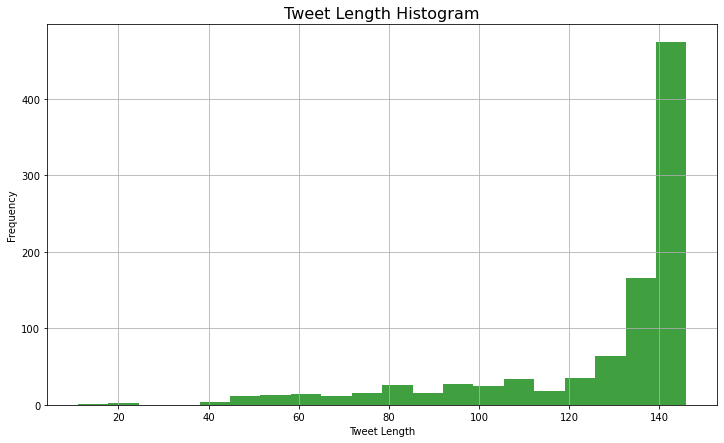

In [16]:
# Plot histograma of the tweet length
fig = plt.figure(figsize = (12, 7))
plt.hist(tweets_len, 20, facecolor='green', alpha=0.75)
plt.title('Tweet Length Histogram', fontsize=16)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 2.4. Stats of Retweets and Favorites

In [17]:
# Get retweet and favorite stats
retweet_count = []
favorite_count = []

for tweet in tweet_list:
    retweet_count.append(tweet['retweet_count'])
    favorite_count.append(tweet['favorite_count'])

In [18]:
# Showing statistics of account tweets
print('Retweets total: %s' % np.sum(retweet_count))
print('Retweets average: %.2f' % np.mean(retweet_count))
print('Favorites total: %s' % np.sum(favorite_count))
print('Favorites average: %.2f' % np.mean(favorite_count))

Retweets total: 1132
Retweets average: 1.18
Favorites total: 8277
Favorites average: 8.62


In [19]:
# Top 15 most popular tweets
df = pd.DataFrame(tweet_list)
df.drop('id', axis=1, inplace=True)
df.drop('user_mentions', axis=1, inplace=True)
df.drop('retweeted', axis=1, inplace=True)
df.sort_values(by=['retweet_count', 'favorite_count'], ascending=False).head(15)

,created_at,user_name,lang,hashtags,retweet_count,favorite_count,message
163,2021-09-27 17:28:11,Even_Oldridge,en,RecSys2021,36,125,Incredibly excited and proud to share work by ...
593,2021-09-29 07:37:27,usait0,en,RecSys2021,24,76,#RecSys2021 Counterfactual Tutorial participan...
768,2021-09-30 21:10:22,ACM_ToRS,en,"RecSys,RecSys2021",17,39,"Hello world, hello #RecSys community, hello to..."
488,2021-09-20 10:31:01,ACMRecSys,en,,16,61,We are delighted to announce that Cynthia Liem...
441,2021-09-24 15:39:22,AmazonScience,en,,13,61,"As @ACMRecSys approaches, Amazon Scholar Pablo..."
108,2021-09-28 09:09:08,FlorianWilhelm,en,RecSys2021,11,46,Great resource of relevant papers/codes on rec...
466,2021-09-24 00:00:36,FAccTRec,en,RecSys2021,11,20,FAccTRec @ #RecSys2021 is on Saturday! We hope...
808,2021-09-30 17:35:03,RecSys_c,en,,10,32,"EPIC news: At this very minute, Dietmar Jannac..."
465,2021-09-24 07:39:38,ACMRecSys,en,RecSys2021,10,28,"We are buzzing at RecSys HQ, because today is ..."
188,2021-09-27 15:02:56,NVIDIAAI,en,,10,23,Transformers4Rec is a flexible and modular lib...


### 2.5. Tweets Language

In [20]:
# Read iso639_2 languages codes
filename = 'config\iso_lang_codes.csv'
df = pd.read_csv(filename, names = ['iso_code', 'language'], skiprows=1)
lang_dict = dict(zip(list(df.iso_code), list(df.language)))
print('Languages dict length:', len(lang_dict))

Languages dict length: 185


In [21]:
# Count the language of the tweets
lang_list = Counter()

for tweet in tweet_list:
    tweet_lang = tweet['lang']
    if tweet_lang in lang_dict.keys():
        lang = lang_dict[tweet['lang']]
        lang_list[lang] += 1
    else:
        print('Missing:', tweet_lang)

print('Total tweets language: %s' % len(lang_list))

Missing: in
Total tweets language: 8


In [22]:
# Cooking dataframe
df = pd.DataFrame.from_records(lang_list.most_common(), columns = ['language', 'frequency'])

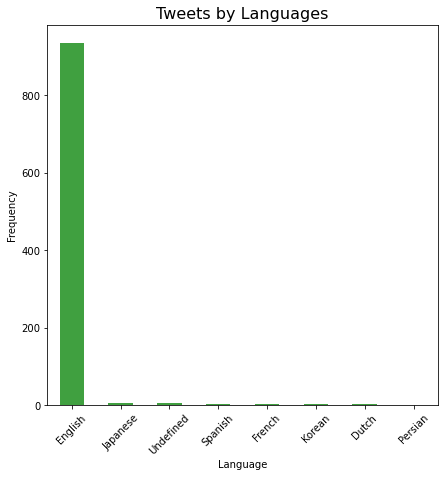

In [23]:
# Plot the language of the tweets
x_var = 'language'
y_var = 'frequency'
title = 'Tweets by Languages'
figsize = (7, 7)
plot_col_chart(df, figsize, x_var, y_var, title)

### 2.6. Tweets by Days

In [24]:
# Count the language of the tweets
tweets_day = Counter()

for tweet in raw_tweet_list:
    created_at = datetime.strptime(tweet['created_at'], '%Y-%m-%d %H:%M:%S').date()
    created_at_str = created_at.strftime('%Y-%m-%d')
    
    tweets_day[created_at] += 1

In [25]:
# Cooking dataframe
df = pd.DataFrame.from_records(list(tweets_day.items()), columns = ['day', 'frequency']).sort_values(by=['day'])
df

,day,frequency
9,2021-09-19,2
8,2021-09-20,26
7,2021-09-21,16
6,2021-09-22,10
5,2021-09-23,23
4,2021-09-24,107
3,2021-09-25,131
2,2021-09-26,77
1,2021-09-27,380
0,2021-09-28,373


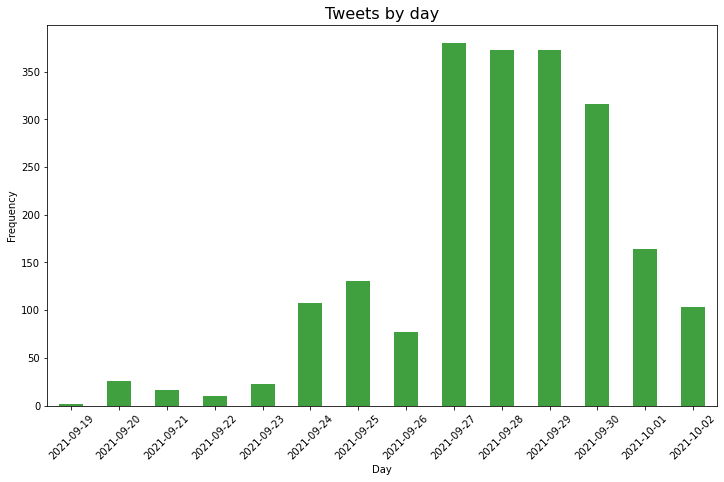

In [26]:
# Plot tweets by day
x_var = 'day'
y_var = 'frequency'
title = 'Tweets by day'
figsize = (12, 7)
color = 'green'
plot_col_chart(df, figsize, x_var, y_var, title, color, None, None)

### 2.7. Tweets by Accounts

In [27]:
# Count the language of the tweets
tweets_account = Counter()

for tweet in raw_tweet_list:
    account_name = tweet['user_name']
    tweets_account[account_name] += 1
    
print('Number of accounts that tweeted:', len(tweets_account))

Number of accounts that tweeted: 520


In [28]:
# Cooking dataframe
n_top = 20
pro_accounts = tweets_account.most_common(n_top)
df = pd.DataFrame.from_records(pro_accounts, columns = ['account', 'frequency']).sort_values(by=['frequency'])
df

,account,frequency
19,samarthbhargav,19
18,SeguraAndres7,20
17,aadi_joshi,21
16,ArjSabet,21
15,dmalitesta,22
14,taoyeah,24
13,olivierjeunen,27
12,peterpaws,29
11,myrthereuver,31
10,mounialalmas,33


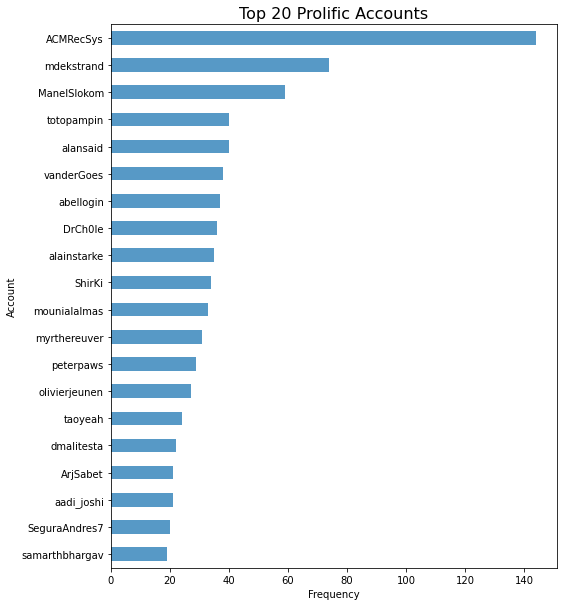

In [29]:
x_var = 'account'
y_var = 'frequency'
title = 'Top %s Prolific Accounts' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 2.8. Most mentioned User Accounts

In [30]:
# Most mentioned accounts list
tw_accounts = Counter()
tw_user_name = "@acmrecsys"

for tweet in raw_tweet_list:
    user_mentions = tweet['user_mentions'].split(",")
    for users in user_mentions:
        if users != "" and users != "ACMRecSys":
            users = "@"+users
            tw_accounts[users] += 1

print('Number of accounts that tweeted:', len(tw_accounts))

Number of accounts that tweeted: 252


In [31]:
# Cooking dataframe
top_accounts = tw_accounts.most_common(n_top)
df = pd.DataFrame.from_records(top_accounts, columns = ['account', 'frequency']).sort_values(by=['frequency'])
df

,account,frequency
19,@walteranelli,24
17,@scne,26
18,@RecSysHR,26
16,@myrthereuver,28
15,@mdekstrand,28
14,@totopampin,31
13,@ngrams,35
12,@sisinflab,36
11,@alainstarke,37
10,@peterpaws,38


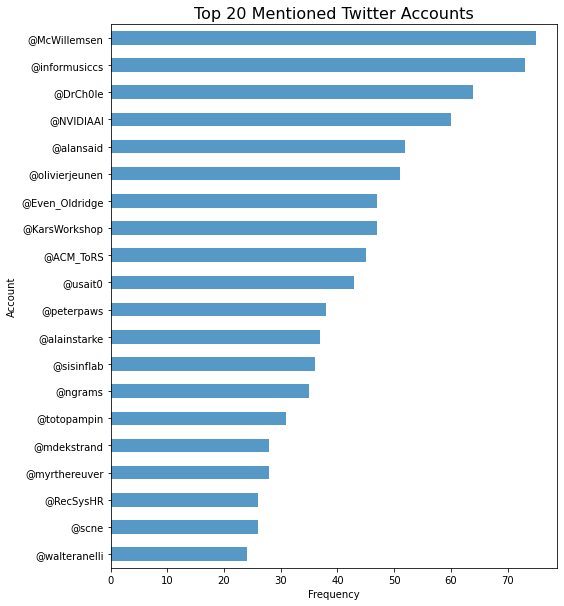

In [32]:
# Plot top N mentioned accounts
x_var = 'account'
y_var = 'frequency'
title = 'Top %s Mentioned Twitter Accounts' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 2.9. Most used Hashtags in Tweets

In [33]:
# Count the hashtags in the tweets and return the N most repeated 
hashtags = Counter()
recsys_ht = 0

for tweet in raw_tweet_list:
    twt_hts = tweet['hashtags'].lower().split(",")
    
    for ht in twt_hts:
        if ht == "recsys2021":
            recsys_ht += 1
            
        elif ht != "" and len(ht) > 0:
            ht = '#'+ht
            hashtags[ht] += 1

print('Total used different hashtags: %s' % len(hashtags))
print('Average hashtags per tweet: %.2f' % (sum(hashtags.values())/n_tweets))
print('Total RecSys2021:', recsys_ht)

Total used different hashtags: 103
Average hashtags per tweet: 0.54
Total RecSys2021: 1275


In [34]:
# Cooking dataframe
top_hashtags = hashtags.most_common(n_top)
df = pd.DataFrame.from_records(top_hashtags, columns = ['hashtag', 'frequency']).sort_values(by=['frequency'])

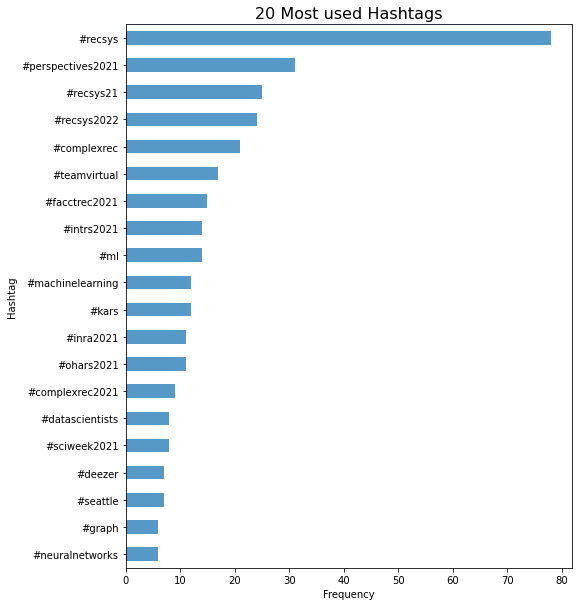

In [35]:
# Plot the most common hashtags in tweets
x_var = 'hashtag'
y_var = 'frequency'
title = '%s Most used Hashtags' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

## 3. NLP Analytics

In [36]:
# Global NLP variables
punt_marks = ['\n', '\'', '\\', '/', '¡', '!', '¿', '?', '.', ',', ';', ':', '_', '-', '#', '$', '%', '&', '(', ')', '"']
rx = '[' + re.escape(''.join(punt_marks)) + ']'

In [37]:
# Util function - Clean tweet text
def dq_clean_text(text):
    clean_text = text.lower()
    clean_text = re.sub(rx, ' ', clean_text)
    clean_text = re.sub(r'\.+', ' ', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    return clean_text

### 3.1. Number of words per tweets in English

In [38]:
# Get tweets in English
en_tweet_list = [tweet for tweet in raw_tweet_list if tweet["lang"] == "en"]
print('Tweets in English:', len(en_tweet_list))

Tweets in English: 2053


In [39]:
# Counter of used words
word_list = Counter()

# Create list of words
for tweet in en_tweet_list:
    if not tweet["retweeted"]:
        tweet_text = tweet['message']

        # Clean tweet text
        clean_text = dq_clean_text(tweet_text)

        # Save mentioned accounts
        for word in clean_text.split(' '):
            if len(word) and not word.isnumeric():
                word_list[word] += 1

print('Number of words used: %s' % len(word_list))
print('Average words per tweet: %.2f' % (len(word_list) / n_tweets))

Number of words used: 3829
Average words per tweet: 3.99


### 3.2. Most common Words in Tweets

In [40]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter twitter accounts
for word, freq in word_list.most_common():
    if ix == n_top:
        break
    elif len(word) > 2 and word[0] != '@':
        df.loc[ix] = (word, freq)
        ix += 1

# Sorting data by frequency
df = df.sort_values(by=['frequency'])

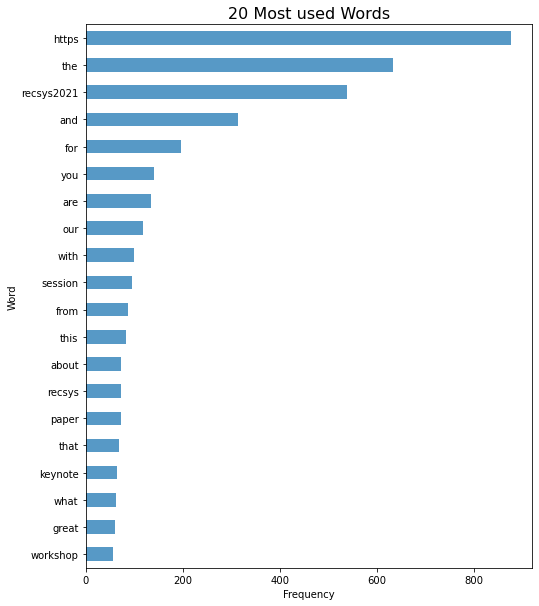

In [41]:
# Plot the most common words in tweets
x_var = 'word'
y_var = 'frequency'
title = '%s Most used Words' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 3.3. Most common Words w/o Stopwords

In [42]:
# Get Spanish stopwords
stopwords_es = es.stop_words.STOP_WORDS
stopwords_en = en.stop_words.STOP_WORDS | set({'http', 'https'})

In [43]:
# Add word-freq to Dataframe
df = pd.DataFrame(columns=['word', 'frequency'])
ix = 0

# Filter English and Spanihs stopwords
for word, freq in word_list.most_common():
    if ix == n_top:
        break
    elif (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
        df.loc[ix] = (word, freq)
        ix += 1

# Sorting data by frequency
df = df.sort_values(by=['frequency'])

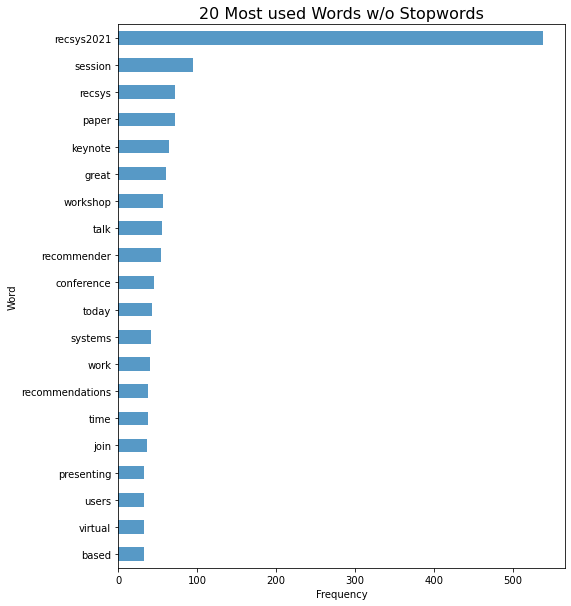

In [44]:
# Plot the most common words in tweets
x_var = 'word'
y_var = 'frequency'
title = '%s Most used Words w/o Stopwords' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 3.4. Most common Bigrams  w/o Stopwords

In [45]:
# Calculate most common bigrams and reconstruct full text with used words
new_clean_text = ""
bigram_list = Counter()

# Create list of words
for tweet in tweet_list:
    tweet_text = tweet['message']
    clean_text = dq_clean_text(tweet_text)
    
    tokens = clean_text.split(' ')
    bigram = ''
    last_word = ''
    for i in range(0, len(tokens)):
        word = tokens[i]
        if (word not in stopwords_es) and (word not in stopwords_en) and (len(word) > 2) and (word[0] != '@'):
            
            # Reconstructing the clean text (without stop-words)
            new_clean_text += ' ' + word
            
            # Add bigrams-freq to Dataframe
            if last_word != "":
                bigram = last_word + '-' + word
                bigram_list[bigram] += 1
            
            last_word = word

print('Total different bigrams: %s' % len(bigram_list))

Total different bigrams: 6304


In [46]:
# Cooking dataframe
top_bigrams = bigram_list.most_common(n_top)
df = pd.DataFrame.from_records(top_bigrams, columns = ['bigram', 'frequency']).sort_values(by=['frequency'])

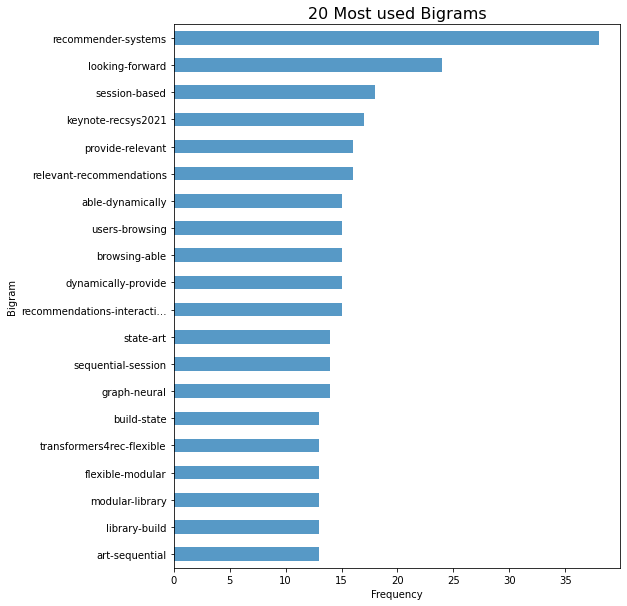

In [47]:
# Plot the most common words in tweets
x_var = 'bigram'
y_var = 'frequency'
title = '%s Most used Bigrams' % n_top
figsize = (8, 10)
plot_bar_chart(df, figsize, x_var, y_var, title)

### 3.5. Tweet WordCloud

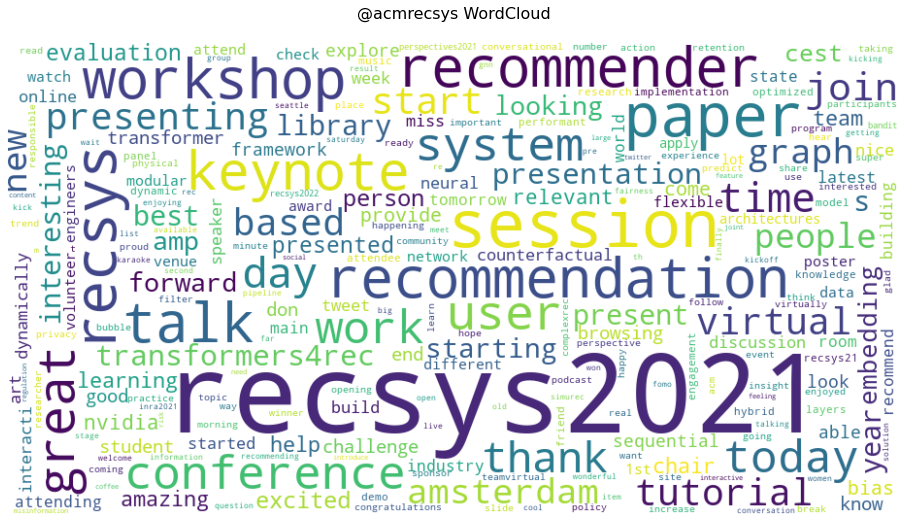

In [48]:
# Load mask
mask = np.array(Image.open('../img/twitter-mask.png'))

# Create a Word-cloud
wc = WordCloud(background_color="white", max_words=250, mask=mask, collocations=False, margin=2)
wc = wc.generate(new_clean_text)

# Plot a Word-cloud of words of tweets
plt.figure(figsize = (16, 10))
image = plt.imshow(wc, interpolation = "bilinear")
plt.title('%s WordCloud\n' % tw_user_name, fontsize=16)
plt.axis("off")

# Save the Word-cloud image
plt.savefig('../img/wordcloud.png')
plt.show()

## 4. Network Analytics

### 4.1. Create Network

In [49]:
# Counting nodes and edges
edge_counter = Counter()

for tweet in raw_tweet_list:
    source = tweet['user_name'].lower()
    targets = tweet['user_mentions'].lower().split(",")
    
    for target in targets:
        if target != "" and source != target:
            edge = source + "-" + target
            edge_counter[edge] += 1

print('Total edge list:', len(edge_counter))
print(edge_counter.most_common(10))

Total edge list: 1773
[('manelslokom-acmrecsys', 28), ('mdekstrand-drch0le', 16), ('abellogin-acmrecsys', 16), ('drch0le-acmrecsys', 12), ('mdekstrand-acmrecsys', 10), ('acmrecsys-mcwillemsen', 10), ('alainstarke-acmrecsys', 9), ('acmrecsys-informusiccs', 9), ('tommasodinoia-acmrecsys', 9), ('arjsabet-peterpaws', 8)]


In [50]:
node_list = []
edge_list = []
THRESHOLD = 4

# Add weighted edges
for key, weight in edge_counter.items():
    tokens = key.split("-")
    source = tokens[0]
    target = tokens[1]
    
    if weight > THRESHOLD:
        
        # Add nodes
        if source not in node_list:
            node_list.append(source)
        if target not in node_list:
            node_list.append(target)
        
        # Adde edges
        edge_list.append((source, target, weight))

In [51]:
# Create an empty Directed Weighted Graph (DWG)
dwg = nx.DiGraph()
dwg.add_nodes_from(node_list)
dwg.add_weighted_edges_from(edge_list)

### 4.2. Graph density

In [52]:
# Function that calculates the graph density
def get_graph_density(g):
    n_nodes = len(g.nodes())
    n_edges = len(g.edges())
    print('n_nodes:', n_nodes, ', n_edges:', n_edges)
    
    if nx.is_directed(g):
        density = n_edges / (n_nodes * (n_nodes - 1))
    else:
        density = 2 * n_edges / (n_nodes * (n_nodes - 1))
    
    return density

In [53]:
# Calculate the graph density
density = get_graph_density(dwg)
print('graph density:', density)

n_nodes: 35 , n_edges: 46
graph density: 0.03865546218487395


### 4.3. Plot Graph data
#### Adjacency matrix

In [54]:
# Calculate the adjacency between the nodes
adj_mtx = nx.adjacency_matrix(dwg).todense()
adj_mtx

matrix([[0, 7, 0, ..., 0, 0, 0],
        [5, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 6],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

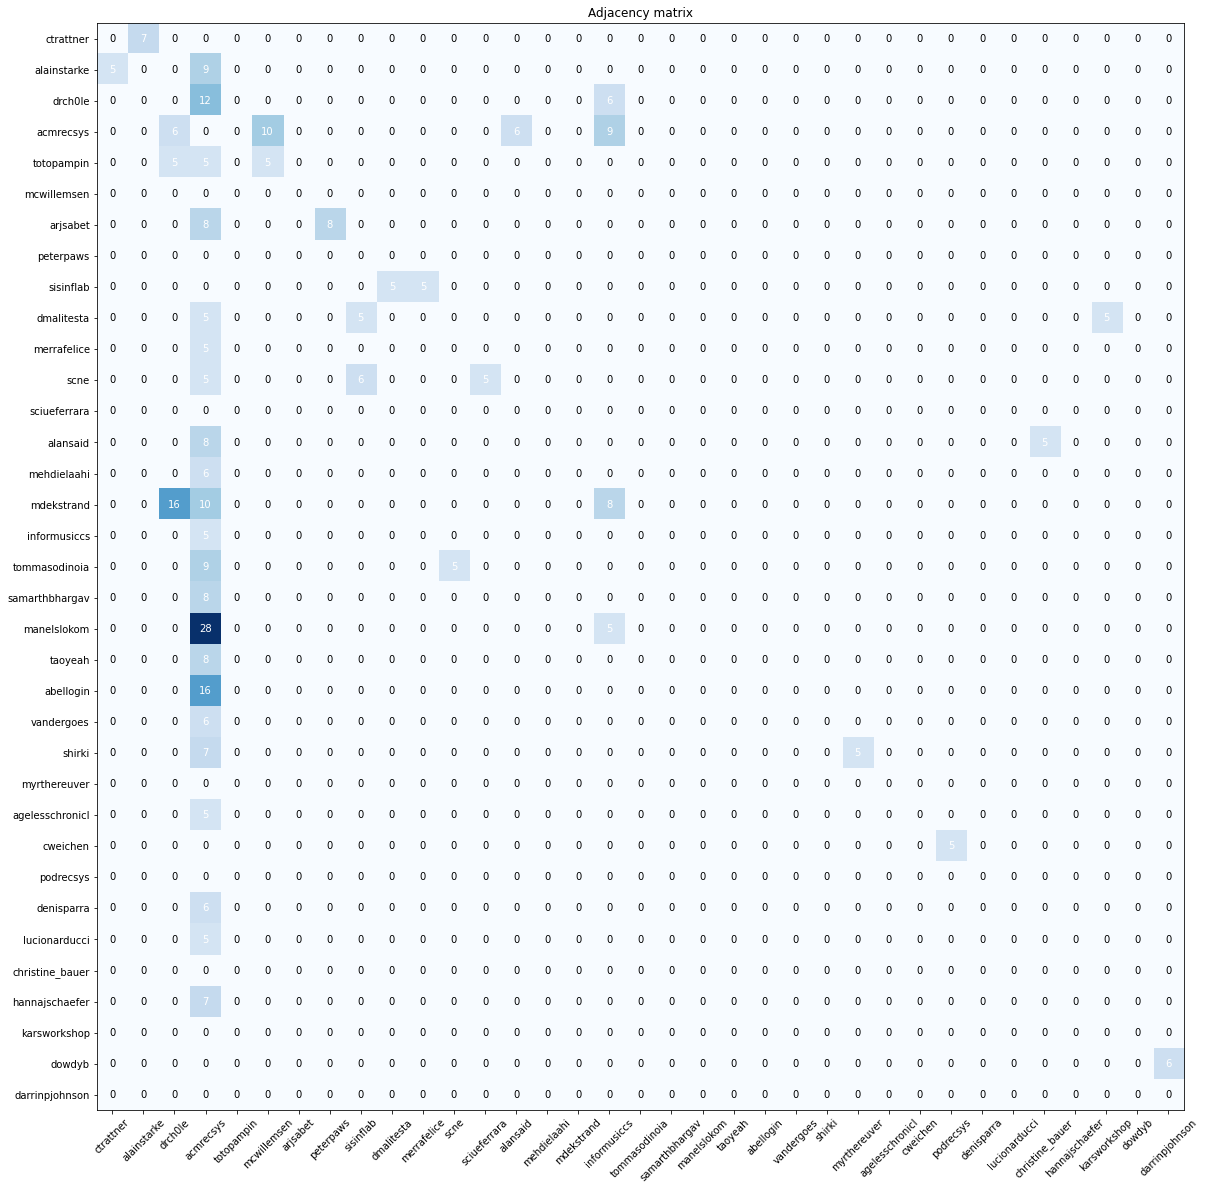

In [55]:
# Plotting the Adjacency matrix
plt.rcParams["figure.figsize"] = [20, 20]
fig, ax = plt.subplots()
ax.imshow(adj_mtx, cmap="Blues")
ax.set_xticks(np.arange(len(node_list)))
ax.set_yticks(np.arange(len(node_list)))
ax.set_xticklabels(node_list, rotation=45)
ax.set_yticklabels(node_list)

for i in range(len(node_list)):
    for j in range(len(node_list)):
        text_color = 'black' if adj_mtx[i, j] == 0 else 'white'
        text = ax.text(j, i, adj_mtx[i, j], ha="center", va="center", color=text_color)

ax.set_title("Adjacency matrix", fontsize=12)
plt.show()

#### Incidence matrix

In [56]:
# Calculate the incidence of the edges on the nodes
inc_mtx = nx.incidence_matrix(dwg).todense()
inc_mtx

matrix([[1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

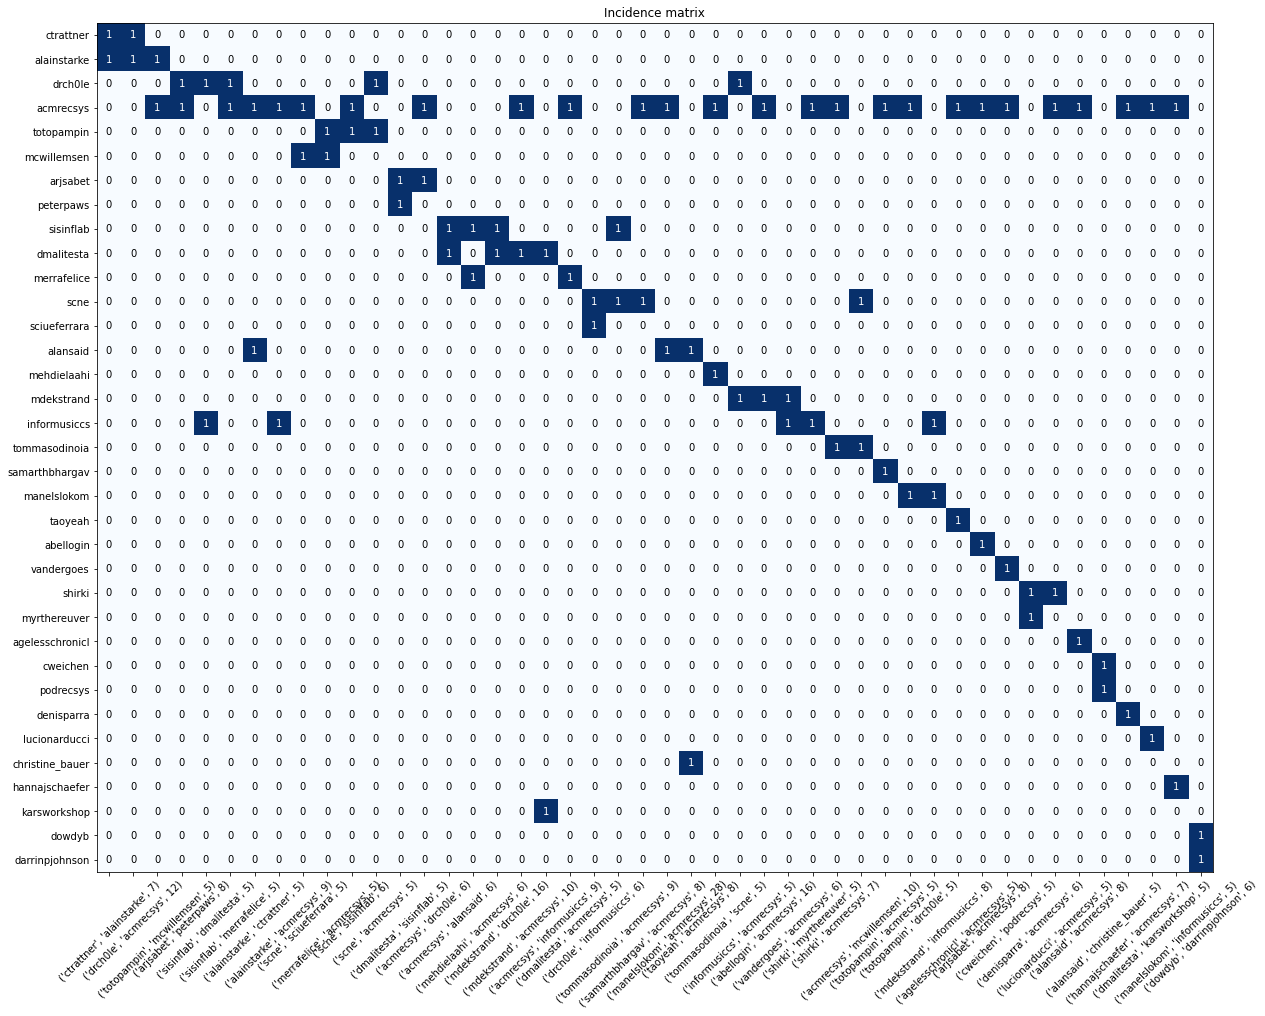

In [57]:
# Plotting the Incidence matrix
fig, ax = plt.subplots()
ax.imshow(inc_mtx, cmap="Blues")
ax.set_xticks(np.arange(len(edge_list)))
ax.set_yticks(np.arange(len(node_list)))
ax.set_xticklabels(edge_list, rotation=45)
ax.set_yticklabels(node_list)

for i in range(len(node_list)):
    for j in range(len(edge_list)):
        text_color = 'black' if inc_mtx[i, j] == 0 else 'white'
        text = ax.text(j, i, int(inc_mtx[i, j]), ha="center", va="center", color=text_color)

ax.set_title("Incidence matrix", fontsize=12)
plt.show()

#### Plotting Directed Weighted Graph

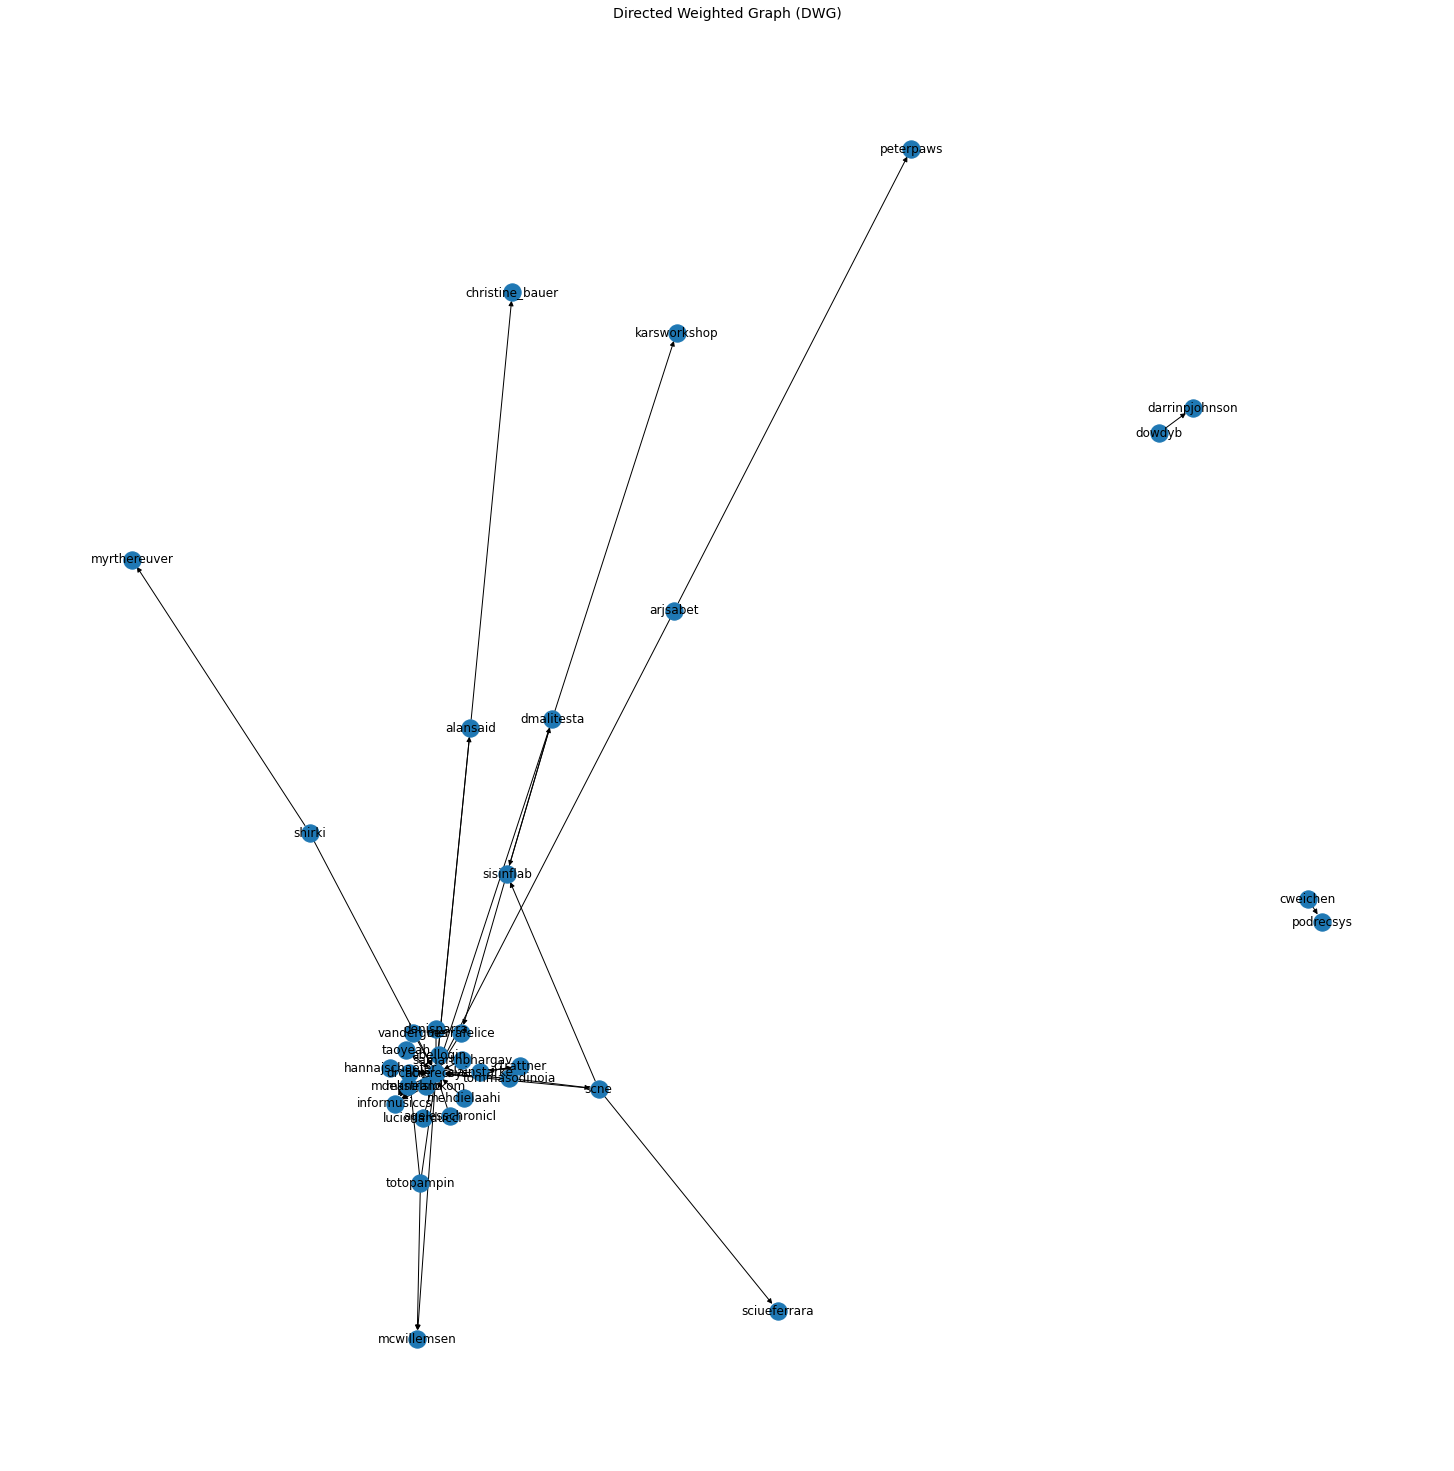

In [58]:
# Plot Undirected Simple Graph (free format)
plt.rcParams["figure.figsize"] = [20, 20]
nx.draw(dwg, with_labels=True)
plt.title('Directed Weighted Graph (DWG)', fontsize=14)
plt.axis('off')
plt.show()

### 4.4. Export data

In [59]:
# Util function - save json to json file
def export_json_to_json_file(json_path:str, json_data:dict) -> None:
    
    # Create JSON file
    with open(json_path, "w") as outfile:
        json.dump(json_data, outfile)

# Util function - save list to CSV file
def export_list_to_csv_file(csv_path:str, header:list, data:list) -> None:
    
    # Using csv.writer method from CSV package
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        write = csv.writer(f)
        write.writerow(header)
        for row in data:
            write.writerow(row)

In [60]:
# Create JSON file
json_data = {"nodes": [], "links":[]}
node_list = []

# Add weighted edges
for key, weight in edge_counter.items():
    tokens = key.split("-")
    source = tokens[0]
    target = tokens[1]
    
    # Adde edges
    if source not in node_list:
        node_list.append(source)
    if target not in node_list:
        node_list.append(target)
    json_data["links"].append({"source": source, "target": target, "value": weight})

for node in node_list:
    json_data["nodes"].append({"id": node, "group": 1 if node in node_list else 2})

# Save JSON file
json_filepath = "../data/graph_data.json"
export_json_to_json_file(json_filepath, json_data)

In [61]:
# Create CSV file
header = ["source", "target", "weight"]
csv_data = []

# Add weighted edges
for key, weight in edge_counter.items():
    tokens = key.split("-")
    source = tokens[0]
    target = tokens[1]
    csv_data.append([source, target, weight])

# Save CSV file
csv_filepath = "../data/graph_data.csv"
export_list_to_csv_file(csv_filepath, header, csv_data)

<hr>
<p><a href="https://github.com/ansegura7/recsys-tweet-analysis">« Home</a></p>